In [19]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond


import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from scipy.optimize import minimize_scalar

# Forcing Terms

In [2]:
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]

# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12
def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]

# Parameters

In [151]:
file_name = 'shape_search'

node_sets = ['spiral']
ns = [200 * 2**i for i in range(0,8)]
#ns = [100, 200, 300]
print(ns)

#rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9', 'gaussian']
#rbf_labels = ['r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
#rbf_labels = ['r^3', 'r^5', 'r^6*log(r)', 'r^9', 'gaussian']
rbf_labels = ['gaussian']
#rbf_labels = ['r^3']

#epsilons = [1, .5, .25, .1, .05]
#epsilons = [1, .05]
#epsilons = [.1, .01, .001]
epsilons = [1]
#epsilons = [4, 2, 1, .5, .25]

basis_degs = [0] # -1 for no terms
basis_types = ['p'] * len(basis_degs) # p for polynomial and s for spherical harmonics



foo, exact = foo2, exact2

#stencil_sizes = [7, 11, 31]
stencil_sizes = [11, 31]
#stencil_sizes = [31]

calculate_weights_cond = False
calculate_stencil_conds = True

optimize_epsilon = True
target_cond = 10**14
optimize_all_stencils = True

[200, 400, 800, 1600, 3200, 6400, 12800, 25600]


# RBFs

In [76]:
rbf_dict = {}

even_tol = 1e-14

def rbf(r):
    return r**3
def d_phi_dr_div_r(r):
    return 3 * r
rbf_dict['r^3'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**2 * (1 + 4*np.log(r))
rbf_dict['r^4*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**5
def d_phi_dr_div_r(r):
    return 5 * r**3
rbf_dict['r^5'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * (1 + 6*np.log(r))
rbf_dict['r^6*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**7
def d_phi_dr_div_r(r):
    return 7 * r**5
rbf_dict['r^7'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**8 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * (1 + 8*np.log(r))
rbf_dict['r^8*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**9
def d_phi_dr_div_r(r):
    return 9 * r**7
rbf_dict['r^9'] = (rbf, d_phi_dr_div_r)

# RBFs with Shape Parameter
shape_rbfs = []

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)
rbf_dict['gaussian'] = (rbf, d_phi_dr_div_r)
shape_rbfs += ['gaussian']



def grad_rbf(node, node_center):
    r = dist(node, node_center)
    return d_phi_dr_div_r(r) * (np.array(node) - np.array(node_center))

########################################################################################
#
# misc
#
########################################################################################

def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

# Basis Terms

In [77]:
# Returns 
#    P - matrix of polynomial basis terms evaluated at nodes relative to the first node (center)
#    rhs_x, rhs_y, rhs_z - the projected partial derivatives of the basis with respect to each x,y, and z
#       evaluated at each node relative to the first node (center)
def get_poly_basis(deg, nodes, projectors):
    num_nodes = len(nodes)
    if deg == -1:
        P = np.zeros((num_nodes, 0))
        rhs_x = np.zeros((0, num_nodes))
        rhs_y = np.zeros((0, num_nodes))
        rhs_z = np.zeros((0, num_nodes))
        return P, rhs_x, rhs_y, rhs_z
    if deg == 0:
        P = np.ones((num_nodes, 1))
        rhs_x = np.zeros((1, num_nodes))
        rhs_y = np.zeros((1, num_nodes))
        rhs_z = np.zeros((1, num_nodes))
        return P, rhs_x, rhs_y, rhs_z
    
    if deg == 1:
        P = np.ones((num_nodes, 4))
        P[:,1:] = nodes - nodes[0]
        
        rhs_x = np.array([ proj@[[1],[0],[0]] for proj in projectors])
        rhs_x = rhs_x.reshape((num_nodes,3)).T
        rhs_x = np.block([[np.zeros((1, num_nodes))], [rhs_x]])
        
        rhs_y = np.array([ proj@[[0],[1],[0]] for proj in projectors])
        rhs_y = rhs_y.reshape((num_nodes,3)).T
        rhs_y = np.block([[np.zeros((1, num_nodes))], [rhs_y]])

        rhs_z = np.array([ proj@[[0],[0],[1]] for proj in projectors])
        rhs_z = rhs_z.reshape((num_nodes,3)).T
        rhs_z = np.block([[np.zeros((1, num_nodes))], [rhs_z]])

        return P, rhs_x, rhs_y, rhs_z
        


# Epsilon Optimization

In [118]:
def root_find(eps, dist_mat, P, target_cond):
    A = np.exp(-(eps*dist_mat)**2)
    AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
    return np.log(cond(AP)/target_cond) ** 2

def check_eps(eps, dist_mat):
    A = np.exp(-(eps*dist_mat)**2)
    return cond(A)

In [79]:
dist_mat = np.array([[dist(node, node_center) for node in nn] for node_center in nn])
for eps in np.linspace(.33296, .33297, 20):
    print(eps, root_find(eps, dist_mat, 10**14))

0.33296 45.12469704113162
0.33296052631578943 66.95784312471844
0.33296105263157894 75.25615924050109
0.3329615789473684 59.599950103173796
0.3329621052631579 49.737523409449715
0.33296263157894734 47.705395139602544
0.33296315789473685 44.05753171865604
0.3329636842105263 63.296763811334785
0.33296421052631575 44.90993975504898
0.33296473684210526 54.142192038883074
0.3329652631578947 45.693966114786484
0.3329657894736842 75.29555992909204
0.33296631578947367 59.86649164686552
0.3329668421052631 52.61290084086561
0.3329673684210526 67.8946124085541
0.3329678947368421 43.20986745265137
0.3329684210526316 44.54177710245225
0.33296894736842103 40.12760616036971
0.33296947368421054 41.48176997889531
0.33297 64.06583865294756


In [80]:
my_eps = minimize_scalar(root_find, args=(dist_mat, 10**14))
print(my_eps['x'])
print(my_eps)

0.6283034413768795
     fun: 5.042457539027561e-08
    nfev: 29
     nit: 25
 success: True
       x: 0.6283034413768795


In [81]:
np.log(check_eps(0.3329741548035087, dist_mat))/np.log(10)

17.227083203347828

# Loops

In [152]:
columns = ['node_set', 'rbf',  'epsilon', 'basis_deg', 'basis_type', 'N', 'stencil_size', 'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

assert len(basis_types) == len(basis_degs)
for node_set in node_sets:
    for n in ns:
        print('n: %d' % n)
        # generate nodes
        if node_set == 'spiral':
            indices = np.arange(0, n, dtype=float) + 0.5
            phi = np.arccos(1 - 2*indices/n)
            theta = np.pi * (1 + 5**0.5) * indices
            xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
            nodes = np.array([(x,y,z) for x,y,z in zip(xs,ys,zs)])
        projectors = [np.eye(3) - np.outer(node, node) for node in nodes]

        # generate stencils
        tree = cKDTree(np.array(nodes))
        

        # generate weights
        for rbf_label in rbf_labels:
            print('\trbf: ' + rbf_label)
            rbf, d_phi_dr_div_r = rbf_dict[rbf_label]
            skip_no_epsilon = False
            if optimize_epsilon:
                epsilons = [1]
            for epsilon in epsilons:
                if skip_no_epsilon:
                    continue
                if rbf_label not in shape_rbfs:
                    #epsilon = ''
                    skip_no_epsilon = True
                else:
                    print('\t\tepsilon %f' % epsilon)
                
                for stencil_size in stencil_sizes:
                    if stencil_size > n:
                        stencil_size = n
                    stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                    print('\t\t\tstencil size: %d' % stencil_size)
                    
                    for basis_deg, basis_type in zip(basis_degs, basis_types):
                        if calculate_stencil_conds:
                            largest_stencil_cond = 0
                        else:
                            largest_stencil_cond = '-'
                        
                        weights = np.zeros((n, stencil_size))
                        row_index = [r for r in range(n) for c in range(stencil_size)]
                        col_index = np.zeros((n, stencil_size))
                        for i, stencil in enumerate(stencils):

                            col_index[i] = stencil
                            nn = [nodes[i] for i in stencil]
                            nn_proj = [projectors[i] for i in stencil]
                            center_x, center_y, center_z = nn[0]
                            
                            P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)
                            
                            if optimize_epsilon and (i==0 or optimize_all_stencils):
                                # optimize cond for first stencil
                                dist_mat = np.array([[dist(node, node_center) for node in nn] for node_center in nn])
                                optimization_result = minimize_scalar(root_find, args=(dist_mat, P, target_cond))
                                epsilon = optimization_result['x']
                                if i==0:
                                    print(print('\t\tepsilon %f' % epsilon))

                            A = np.array([[rbf(dist(node, node_center)) for node in nn] for node_center in nn])
                            #P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
                            #P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)

                            num_basis = P.shape[1]

                            AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                            
                            if calculate_stencil_conds:
                                my_cond = cond(AP)
                                if my_cond > largest_stencil_cond:
                                    largest_stencil_cond = my_cond

                            rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) for j, node in enumerate(nn) ]
                                                for node_center in nn] )

                            rhsA = rhsAs[:,:,0] # only the x coordinates
                            rhs = np.block([[rhsA],
                                            [rhs_x]])
                            weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                            weights[i] = (weights_grad@weights_grad)[0]

                            rhsA = rhsAs[:,:,1] # only the y coordinates
                            rhs = np.block([[rhsA],
                                            [rhs_y]])
                            weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                            weights[i] += (weights_grad@weights_grad)[0]

                            rhsA = rhsAs[:,:,2] # only the z coordinates
                            rhs = np.block([[rhsA],
                                            [rhs_z]])
                            weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                            weights[i] += (weights_grad@weights_grad)[0]

                        C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

                        # solve steady-state
                        C = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                                        np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')
                        rhs = [-foo(node) for node in nodes] + [0]
                        if calculate_weights_cond:
                            weights_cond = cond(C.todense())
                        else:
                            weights_cond = '-'
                        u = spsolve(C, rhs)
                        u = u[:-1]
                        u_true = np.array([exact(node) for node in nodes])
                        data = data.append( 
                            {'node_set': node_set, 'rbf':rbf_label, 'epsilon': epsilon,
                             'basis_deg':np.int(basis_deg), 'basis_type' : basis_type,
                             'N':n, 'stencil_size':stencil_size,
                             'max_error':np.max( np.abs(u-u_true ) ), 
                             'rel_L2_error':la.norm(u-u_true)/la.norm(u_true),
                             'stencil_cond': largest_stencil_cond, 
                             'weights_cond': weights_cond,
                             'target_cond' : target_cond}, ignore_index=True)


n: 200
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.024992
None
			stencil size: 31
		epsilon 0.258883
None
n: 400
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.035476
None
			stencil size: 31
		epsilon 0.402387
None
n: 800
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.050272
None
			stencil size: 31
		epsilon 0.630189
None
n: 1600
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.084581
None
			stencil size: 31
		epsilon 0.953855
None
n: 3200
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.165595
None
			stencil size: 31
		epsilon 1.418632
None
n: 6400
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.311650
None
			stencil size: 31
		epsilon 2.079108
None
n: 12800
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.537555
None
			stencil size: 31
		epsilon 3.005472
None
n: 25600
	rbf: gaussian
		epsilon 1.000000
			stencil size: 11
		epsilon 0.850323
None
			st

In [153]:
display(data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,target_cond,weights_cond
0,spiral,gaussian,0.024988,0,p,200,11,0.017085,0.012065,1.002493e+14,1.000000e+14,-
1,spiral,gaussian,0.258892,0,p,200,31,0.000081,0.000100,1.000655e+14,1.000000e+14,-
2,spiral,gaussian,0.035477,0,p,400,11,0.004033,0.003547,1.002938e+14,1.000000e+14,-
3,spiral,gaussian,0.402406,0,p,400,31,0.000014,0.000010,4.081605e+14,1.000000e+14,-
4,spiral,gaussian,0.050280,0,p,800,11,0.001561,0.001553,1.007801e+14,1.000000e+14,-
5,spiral,gaussian,0.630181,0,p,800,31,0.000009,0.000009,1.417212e+14,1.000000e+14,-
6,spiral,gaussian,0.084465,0,p,1600,11,0.001000,0.001012,1.189481e+14,1.000000e+14,-
7,spiral,gaussian,0.953787,0,p,1600,31,0.000022,0.000021,1.316302e+14,1.000000e+14,-
8,spiral,gaussian,0.165677,0,p,3200,11,0.000358,0.000354,1.161651e+14,1.000000e+14,-
9,spiral,gaussian,1.418784,0,p,3200,31,0.000034,0.000031,1.008953e+14,1.000000e+14,-


# Write to File

In [154]:
i = 0
file_name_num = file_name + '_' + str(i) + '.pickle'
while os.path.isfile(os.path.join('pickles',file_name_num)):
    i += 1
    file_name_num = file_name + '_' + str(i) + '.pickle'

f = open(os.path.join('pickles',file_name_num), 'wb')
pickle.dump(data, f)
f.close()
print(file_name_num)

shape_search_2.pickle


In [155]:
read_data = data

# Read from File

In [22]:
file_to_read = 'shape_3.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()
#basis_degs = read_data.basis_deg.unique()

#read_data['sqrtN'] = np.sqrt(read_data['N'])

In [48]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,weights_cond
0,spiral,gaussian,4,0,p,200,11,0.300476,0.247210,1.987652e+01,-
1,spiral,gaussian,4,0,p,200,31,2.171177,1.964981,4.680759e+01,-
2,spiral,gaussian,2,0,p,200,11,0.123032,0.120866,1.436167e+03,-
3,spiral,gaussian,2,0,p,200,31,0.100929,0.103700,3.968847e+04,-
4,spiral,gaussian,1,0,p,200,11,0.017065,0.016590,2.314055e+05,-
5,spiral,gaussian,1,0,p,200,31,0.001108,0.001098,2.510267e+08,-
6,spiral,gaussian,0.5,0,p,200,11,0.008730,0.008163,2.610336e+07,-
7,spiral,gaussian,0.5,0,p,200,31,0.000241,0.000205,4.810265e+11,-
8,spiral,gaussian,0.25,0,p,200,11,0.011958,0.010366,1.940773e+09,-
9,spiral,gaussian,0.25,0,p,200,31,0.000071,0.000098,5.660459e+14,-


# Plots

In [ ]:
fig, ax_s = plt.subplots(2, sharex=True, figsize=(12,12))
ax_s[0].loglog('N', 'max_error', data=read_data[read_data.stencil_size==31])
ax_s[0].set_title('Max error')
ax_s[1].loglog('N', 'rel_L2_error', data=read_data[read_data.stencil_size==31])
ax_s[1].set_title('Relative $L_2$ error')
plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
#plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
#plt.ylabel('Relative Error')

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.epsilon==1)]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

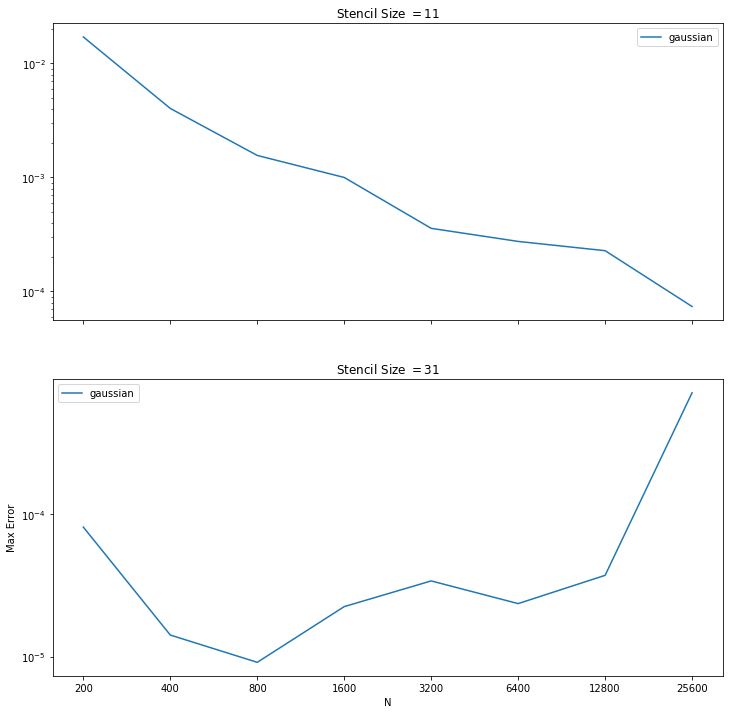

In [158]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

# shape_search_2 - target cond 10^14

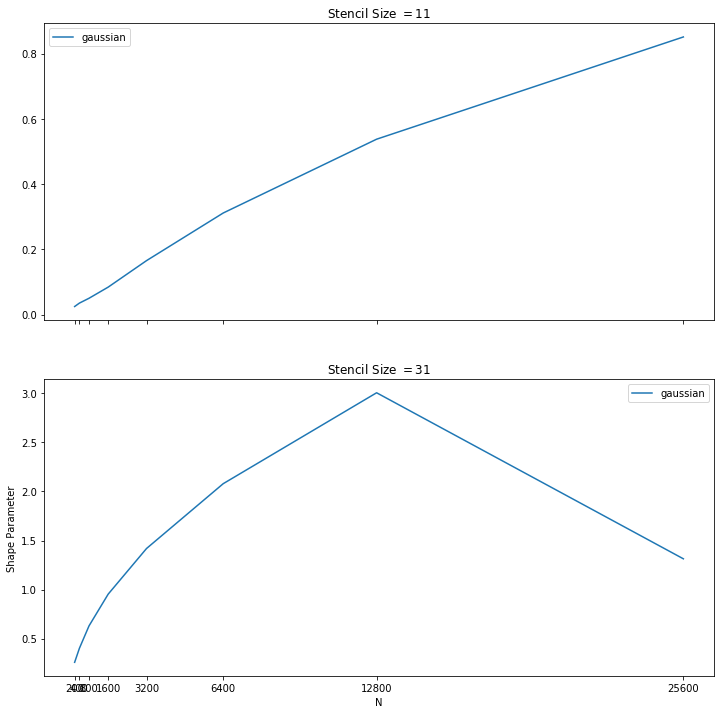

In [156]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].plot( 'N', 'epsilon', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Shape Parameter')
plt.show()

# shape_search_2 - target cond 10^14

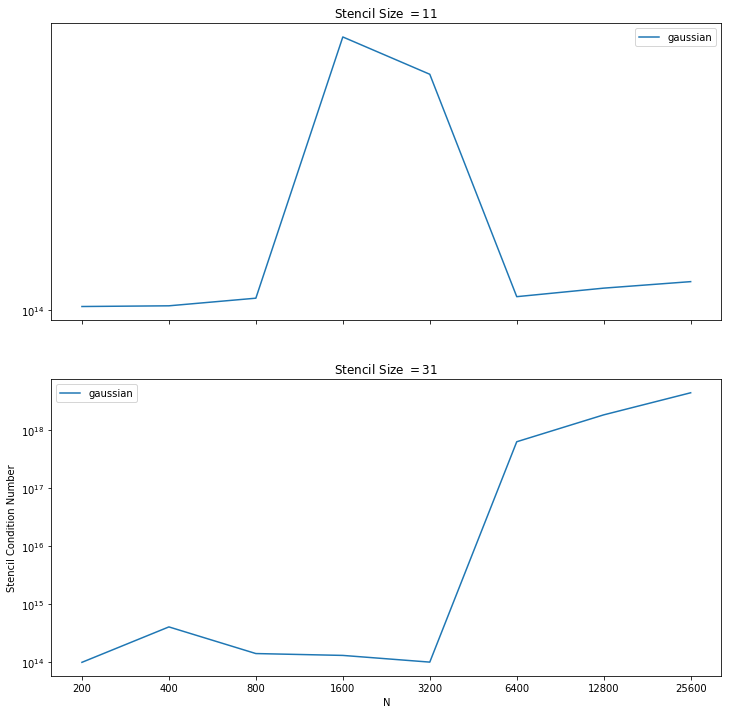

In [157]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Stencil Condition Number')
plt.show()

# shape_search_2 - target cond 10^14

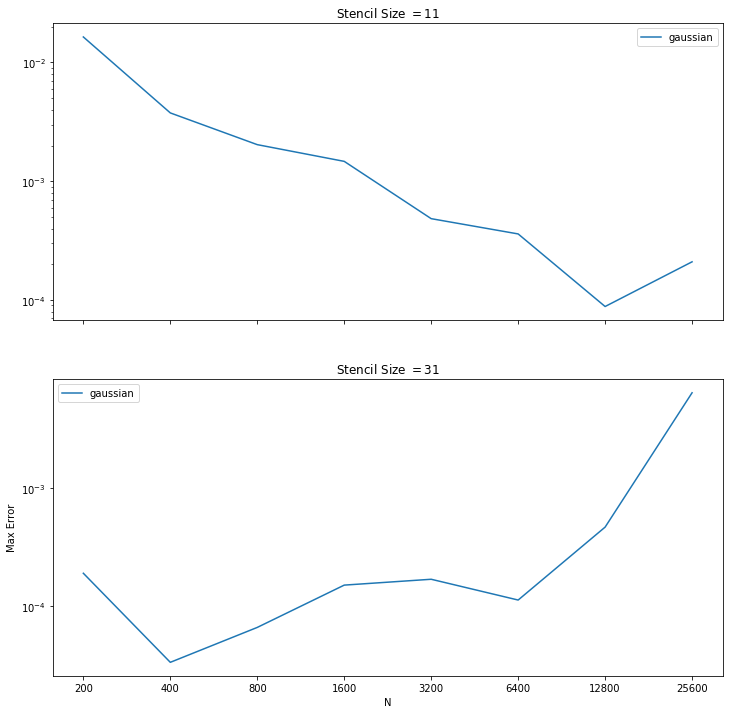

In [147]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

# shape_search_1 - target cond 10^12

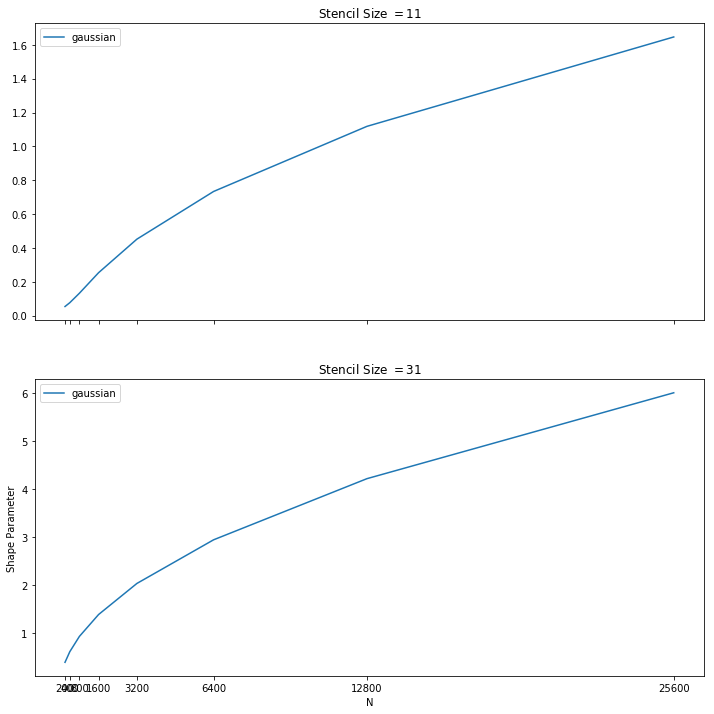

In [148]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].plot( 'N', 'epsilon', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Shape Parameter')
plt.show()

# shape_search_1 - target cond 10^12

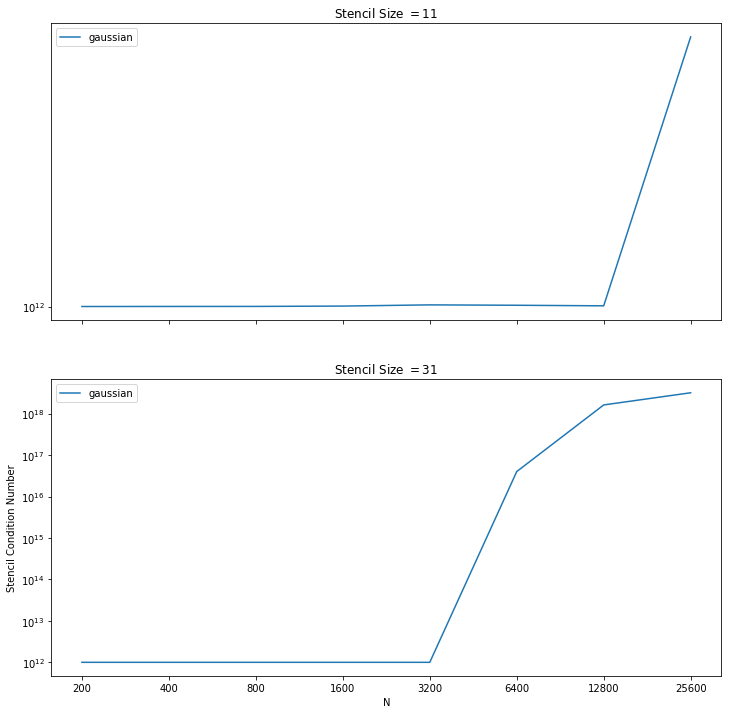

In [149]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Stencil Condition Number')
plt.show()

# shape_search_1 - target cond 10^12

In [141]:
display(read_data[-10:])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,target_cond,weights_cond
2,spiral,gaussian,0.076463,0,p,400,11,0.003763,0.003277,1.000022e+12,1.000000e+12,-
3,spiral,gaussian,0.616967,0,p,400,31,0.000033,0.000025,1.000021e+12,1.000000e+12,-
4,spiral,gaussian,0.132301,0,p,800,11,0.002034,0.002088,1.000025e+12,1.000000e+12,-
5,spiral,gaussian,0.934870,0,p,800,31,0.000066,0.000061,1.000016e+12,1.000000e+12,-
6,spiral,gaussian,0.253591,0,p,1600,11,0.001471,0.001399,1.000051e+12,1.000000e+12,-
7,spiral,gaussian,1.390357,0,p,1600,31,0.000150,0.000142,1.000017e+12,1.000000e+12,-
8,spiral,gaussian,0.451956,0,p,3200,11,0.000484,0.000539,1.000146e+12,1.000000e+12,-
9,spiral,gaussian,2.037936,0,p,3200,31,0.000168,0.000152,1.000147e+12,1.000000e+12,-
10,spiral,gaussian,0.733747,0,p,6400,11,0.000360,0.000341,1.000116e+12,1.000000e+12,-
11,spiral,gaussian,2.946618,0,p,6400,31,0.000112,0.000118,4.026584e+16,1.000000e+12,-


# For Meeting

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')

#plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('rel_L2_error')

#plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('stencil_cond')

#plt.show()

In [ ]:
display(read_data)

In [ ]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==-1]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Not Augmented
#     meeting_0.pickle
#
########################################################################################

In [ ]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==0]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Agumented with constant
#     meeting_0.pickle
#
########################################################################################

In [ ]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==1]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Augmented with linear terms
#     meeting_0.pickle
#
########################################################################################

In [17]:
file_to_read = 'cond_numbers_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()

display(read_data)

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,weights_cond,label
0,spiral,r^3,0.2,1,p,200,7,0.050125,22.559223,4.992054e+02,42.897164,r^3 0.2
1,spiral,gaussian,0.2,1,p,200,7,0.041990,9.203220,1.504166e+08,56.653412,gaussian 0.2
2,spiral,r^3,0.2,1,p,400,7,0.026098,4.307138,1.341322e+03,86.338668,r^3 0.2
3,spiral,gaussian,0.2,1,p,400,7,0.016095,2.013794,1.180640e+09,105.259963,gaussian 0.2
4,spiral,r^3,0.2,1,p,800,7,0.036502,20.743179,3.726019e+03,173.927786,r^3 0.2
5,spiral,gaussian,0.2,1,p,800,7,0.015350,1.834184,9.392575e+09,221.679517,gaussian 0.2
6,spiral,r^3,0.2,1,p,1600,7,0.039006,21.101553,1.047230e+04,359.237964,r^3 0.2
7,spiral,gaussian,0.2,1,p,1600,7,0.006518,0.829760,7.661370e+10,468.887098,gaussian 0.2
8,spiral,r^3,0.2,1,p,3200,7,0.052004,87.619923,2.955462e+04,721.847822,r^3 0.2
9,spiral,gaussian,0.2,1,p,3200,7,0.001273,2.069589,6.175983e+11,921.067813,gaussian 0.2


Text(0,0.5,'max_error')

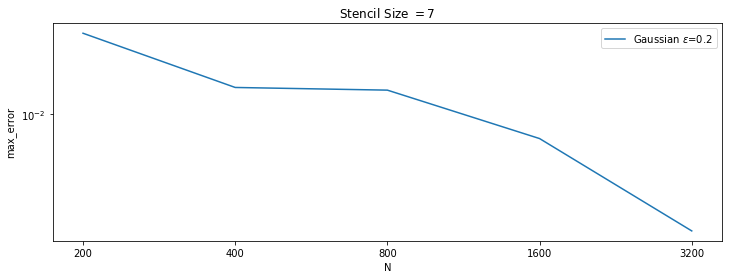

In [18]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,4))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s.loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s.set_title('Stencil Size $=' + str(k) + '$')
    ax_s.legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('max_error')

#plt.show()


Text(0,0.5,'rel_L2_error')

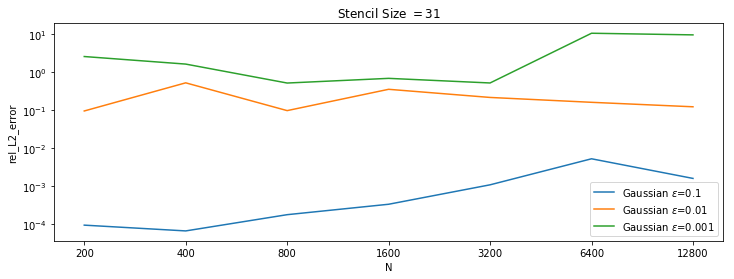

In [23]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,4))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s.loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s.set_title('Stencil Size $=' + str(k) + '$')
    ax_s.legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('rel_L2_error')

#plt.show()